## 1.数据导入与包的加载

In [7]:
import torch.utils.data as data
from torchvision import transforms
from PIL import Image
import os
import torch
import numpy as np
path = "/home/y/project/dm/Palette-Image-to-Image-Diffusion-Models/experiments/test_inpainting_places2_250330_181301/results/test/0/Out_0_0.png"


## 2.函数定义

In [8]:
#图片加载
def loader(path):
    return Image.open(path).convert('RGB')

In [9]:
#数据转换，裁剪，变成张量，标准化
image_size=[256, 256]
tfs = transforms.Compose([
                transforms.Resize((image_size[0], image_size[1])),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5,0.5, 0.5])])

## 3.数据处理

#### 3.1 图片加载

In [10]:
#加载原始图片
img = tfs(loader(path))  #tensor

#加载掩码图片
mask = loader(path).convert("L") #image
mask = np.array(mask)   #ndarray

antenna_mask = mask.copy()    
antenna_region_mask = mask.copy()


FileNotFoundError: [Errno 2] No such file or directory: '/home/y/project/dm/Palette-Image-to-Image-Diffusion-Models/experiments/test_inpainting_places2_250330_181301/results/test/0/Out_0_0.png'

In [83]:
mask[mask > 0] = 1 #1为掩码区

In [84]:
#确定基站位置
indicies = np.argwhere(antenna_mask==255)[0]
x = indicies[0]
y = indicies[1] 
x,y

(np.int64(187), np.int64(108))

In [85]:
# 1. 设置满足条件 0 <= antenna_mask < 255 的像素值为 1
antenna_mask[(antenna_mask >= 0) & (antenna_mask < 255)] = 1

# 2. 将值为 255 的像素值设为 0
antenna_mask[antenna_mask == 255] = 0




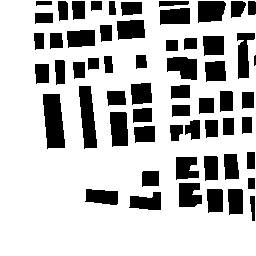

In [86]:
Image.fromarray(mask*255)


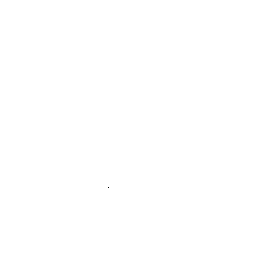

In [87]:
Image.fromarray(antenna_mask*255)


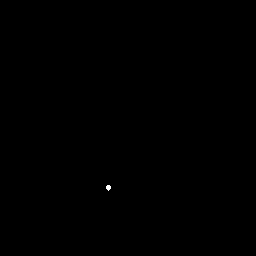

In [107]:
# 3. add antenna region mask .mask .将基站周围的区域设为1,远离的为0.用于计算基站周围的Mse
bound = 230
antenna_region_mask = np.array(loader(path).convert("L") )
antenna_region_mask[(antenna_region_mask >=0) & (antenna_region_mask <= bound)] = 0
antenna_region_mask[antenna_region_mask > bound] = 1
Image.fromarray(antenna_region_mask*255)


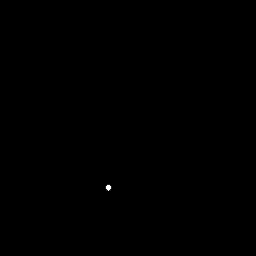

### 3.2 图片查看

In [11]:
mask= torch.tensor(np.expand_dims(mask, axis=0))  # 添加新维度，变为 (1, H, W)  #mask 是图片的掩码。掩码区域为1.。。...
antenna_mask= torch.tensor(np.expand_dims(antenna_mask, axis=0))  # 1.添加新维度，变为 (1, H, W)  #antenna_mask 是图片的掩码。掩码区域为1.。。...


In [12]:
#掩码图像
mask_img = img*(1. - mask) + mask  #3,256,256

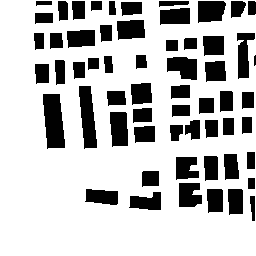

In [13]:
Image.fromarray(np.uint8(mask_img.permute(1,2,0)* 255)) 

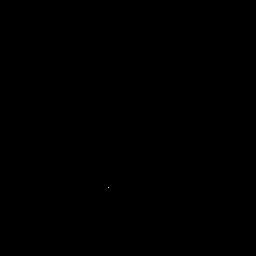

In [14]:
#基站图像
cond_image = img*(1. - antenna_mask) 
Image.fromarray(np.uint8(cond_image.permute(1,2,0)* 255)) 

-------

## 高斯热图

In [1]:
import numpy as np
import torch

def generate_heatmap(H, W, x_norm, y_norm, sigma=5):
    # 生成网格坐标
    y_indices, x_indices = torch.meshgrid(
        torch.arange(H, dtype=torch.float32),
        torch.arange(W, dtype=torch.float32),
        indexing='xy'
    )
    
    # 计算高斯响应
    heatmap = torch.exp(
        -((x_indices - x_norm)**2 + (y_indices - y_norm)**2) / (2 * sigma**2)
    )
    
    # 归一化到 [0, 1]
    heatmap = heatmap / heatmap.max()
    return heatmap  # 形状 (H, W)

# 示例：在 256x256 图像中，基站坐标为 (100, 80)
sigma =70
H, W = 256, 256
x_norm, y_norm = x,y
heatmap = generate_heatmap(H, W, x_norm, y_norm, sigma)

NameError: name 'x' is not defined

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
Image.fromarray((heatmap.numpy() * 255).astype(np.uint8))


NameError: name 'heatmap' is not defined

In [17]:
heatmap.shape

torch.Size([256, 256])

#### 1.将高斯热图和条件图混合

In [18]:
cond_img = img*(1. - mask) + mask*torch.randn_like(img) #3,256,256

In [19]:
cond_img_add = cond_img+ heatmap # 高斯图加条件图

In [2]:
Image.fromarray(np.uint8(cond_img_add.permute(1,2,0)* 255)) 

NameError: name 'Image' is not defined

#### 2.将高斯热图和噪声混合

In [21]:
torch.randn((3,3))

tensor([[-2.6135, -1.3912,  0.4599],
        [ 0.2048, -1.0396, -0.3260],
        [ 1.2583,  1.0563, -1.4132]])

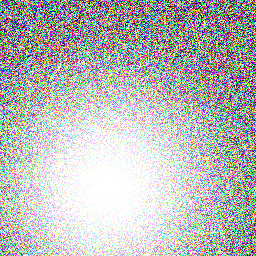

In [22]:
torch.manual_seed(42)

lambda_weight = 1

# 对噪声的两种处理
x_T_rgb = torch.randn(8,3,H, W).clamp(-1, 1) * 0.5 + 0.5  # 1.映射到[0,1]
# x_T_rgb = torch.randn(H, W) # 2.不映射到[0,1]

# 生成热图并归一化
heatmap_1 = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

# 叠加操作
x_T_mixed_rgb = x_T_rgb + heatmap_1*lambda_weight   # 控制热图强度
x_T_mixed_rgb = x_T_mixed_rgb.clamp(0, 1)  # 裁剪到有效范围


# x_T_rgb = torch.randn( H, W)
# # heatmap_rgb = heatmap.unsqueeze(0).repeat(3, 1, 1)  # 形状 (3, H, W)
# x_T_mixed_rgb = x_T_rgb + lambda_weight * heatmap
Image.fromarray(np.uint8(x_T_mixed_rgb[0].permute(1,2,0)*255)) 

In [23]:
import torch.nn.functional as F
# 高斯平滑核
def gaussian_filter(kernel_size=3, sigma=1):
    x = torch.linspace(-sigma, sigma, kernel_size)
    g = torch.exp(-x**2/(2*sigma**2))
    return g/g.sum()

# 应用平滑
smoothed_heatmap = F.conv2d(
    heatmap.unsqueeze(0).unsqueeze(0), 
    gaussian_filter().reshape(1,1,-1,1)
)


In [24]:
smoothed_heatmap

tensor([[[[0.0089, 0.0091, 0.0093,  ..., 0.0034, 0.0033, 0.0032],
          [0.0093, 0.0095, 0.0097,  ..., 0.0036, 0.0035, 0.0034],
          [0.0096, 0.0098, 0.0100,  ..., 0.0037, 0.0036, 0.0035],
          ...,
          [0.1976, 0.2020, 0.2065,  ..., 0.0760, 0.0738, 0.0716],
          [0.1950, 0.1993, 0.2037,  ..., 0.0750, 0.0728, 0.0707],
          [0.1924, 0.1966, 0.2010,  ..., 0.0740, 0.0719, 0.0697]]]])

In [25]:
x_T_mixed_rgb

tensor([[[[1.0000e+00, 1.0000e+00, 9.5623e-01,  ..., 7.8294e-01,
           7.5299e-01, 6.1123e-01],
          [1.6308e-01, 7.8780e-01, 6.2191e-03,  ..., 7.1191e-01,
           3.3077e-01, 7.5911e-01],
          [6.1650e-03, 6.0285e-01, 2.0141e-01,  ..., 4.5267e-04,
           2.8544e-01, 7.8833e-01],
          ...,
          [2.1323e-01, 9.5541e-01, 5.2274e-01,  ..., 7.0888e-01,
           6.3774e-01, 4.9519e-01],
          [5.5876e-01, 1.0000e+00, 1.0000e+00,  ..., 4.9082e-01,
           2.0467e-01, 6.6833e-02],
          [1.8722e-01, 8.0717e-01, 4.2623e-01,  ..., 9.3021e-01,
           3.5630e-01, 1.0000e+00]],

         [[9.4969e-01, 1.0000e+00, 5.8704e-03,  ..., 1.9153e-04,
           1.0796e-02, 6.8814e-01],
          [8.5975e-01, 3.5078e-01, 6.3058e-02,  ..., 7.3219e-01,
           2.3217e-01, 8.5183e-01],
          [6.6826e-01, 6.3709e-03, 1.0000e+00,  ..., 8.2036e-01,
           5.4304e-01, 3.2236e-01],
          ...,
          [1.9250e-01, 1.0000e+00, 7.4098e-01,  ..., 7.2142

In [41]:
torch.cat([cond_image,cond_image], dim=1).shape

torch.Size([3, 512, 256])

## 4.计算得分

#### 4.1 计算rmse

In [44]:
g_pth = "/home/data/cpu-two/code/diffusionmodel/Palette-Image-to-Image-Diffusion-Models/g_image/GT_682_34.png"
s_path = "/home/data/cpu-two/code/diffusionmodel/Palette-Image-to-Image-Diffusion-Models/experiments/train_inpainting_places2_250226_101345/results/val/18/Out_682_34.png"
import numpy as np
from PIL import Image

# 加载图像
g_image = Image.open(g_pth).convert('L')  # 转换为灰度图像
s_image = Image.open(s_path).convert('L')

# 将图像转换为NumPy数组

g_image_np = np.array(g_image).astype(np.float32)  #uint8存在减法溢出

s_image_np = np.array(s_image).astype(np.float32)
# 确保图像大小相同
assert g_image_np.shape == s_image_np.shape, "图像大小不匹配"

# 计算RMSE
rmse = np.sqrt(np.mean((g_image_np - s_image_np) ** 2))

print(f'RMSE: {rmse}')


RMSE: 6.876730918884277


##### 4.2画出残差图

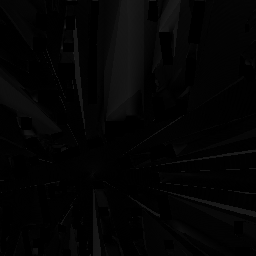

In [58]:

# 转换为浮点型数组
g_array = np.array(g_image).astype(np.float32)
s_array = np.array(s_image).astype(np.float32)

# 形式一：绝对差值图
abs_diff = np.abs(g_array - s_array)
Image.fromarray(np.uint8(abs_diff))

#### 4.2.1 多种残存图

/tmp/ipykernel_622252/3896804406.py:1: RuntimeWarning: overflow encountered in exp
  exp_abs_diff = np.exp(abs_diff.astype(np.uint8))  # 应用指数函数


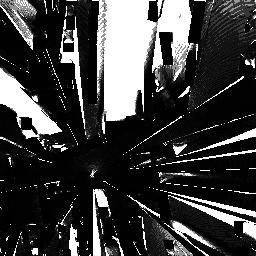

In [59]:

exp_abs_diff = np.exp(abs_diff.astype(np.uint8))  # 应用指数函数


exp_abs_clipped = np.clip(exp_abs_diff, 0, 255).astype(np.uint8)  # 使用 np.clip 替代 clamp

# 保存图像
Image.fromarray(exp_abs_clipped)

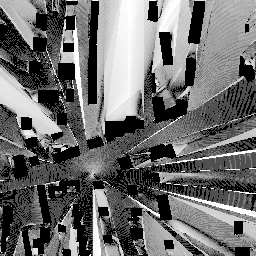

In [64]:
import numpy as np
from PIL import Image
import cv2

# 加载原始残差图（假设已计算绝对差值）
abs_diff = np.abs(g_array - s_array).astype(np.uint8)

# 直方图均衡化
equalized = cv2.equalizeHist(abs_diff)

# 保存结果
Image.fromarray(equalized)

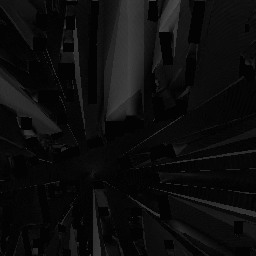

In [65]:
# 创建CLAHE对象
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

# 应用自适应均衡化
clahe_img = clahe.apply(abs_diff)

Image.fromarray(clahe_img)

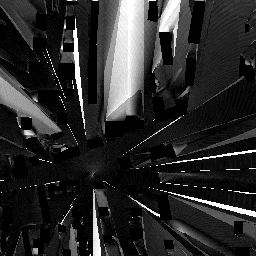

In [67]:
# 定义感兴趣区域（裁剪1%的极端值）
low = np.percentile(abs_diff, 1)
high = np.percentile(abs_diff, 99)

# 线性拉伸公式
stretched = np.clip((abs_diff - low) * (255.0 / (high - low)), 0, 255).astype(np.uint8)

Image.fromarray(stretched)

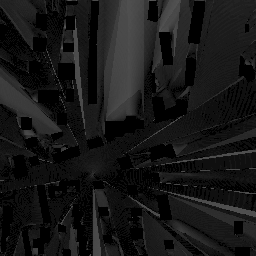

In [69]:
gamma = 0.5  # 调整参数（<1增强暗部，>1增强亮部）

# 归一化到[0,1]
normalized = abs_diff.astype(np.float32) / 255.0

# 伽马变换
gamma_corrected = np.power(normalized, gamma) * 255.0
gamma_corrected = gamma_corrected.astype(np.uint8)

Image.fromarray(gamma_corrected)

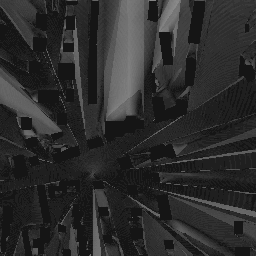

In [73]:
# 第一步：CLAHE预处理
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
temp = clahe.apply(abs_diff)

# 第二步：伽马校正
gamma = 0.6
normalized = temp.astype(np.float32) / 255.0
final = (np.power(normalized, gamma) * 255).astype(np.uint8)

Image.fromarray(final)

#### 4.3 判断基站位置是否完全一致

# 数据加载与掩码制作

In [11]:
import torch.utils.data as data
from torchvision import transforms
from PIL import Image
import os
import torch
import numpy as np
from data.util.mask import (bbox2mask, brush_stroke_mask, get_irregular_mask, random_bbox, random_cropping_bbox)
tfs = transforms.Compose([
                transforms.Resize((256, 256)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5,0.5, 0.5])
                   ])
path = "/home/data/cpu-two/code/dataset/radiomapdataset/RadioMapSeer/gain/carsDPM/0_0.png"


In [12]:
img = tfs(Image.open(path).convert('RGB'))
#在这里改一下mask就行了...
# mask = get_mask()
mask = Image.open(path).convert('RGB').convert("L")
mask = np.array(mask)
antenna_mask = mask
antenna_mask[antenna_mask >=255] =0
antenna_mask[antenna_mask > 0] = 1
antenna_mask= torch.tensor(np.expand_dims(antenna_mask, axis=0))  # 1.添加新维度，变为 (1, H, W)  #antenna_mask 是图片的掩码。掩码区域为1.。。...
cond_image = img*(1. - antenna_mask) 


In [13]:
cond_image.shape

torch.Size([3, 256, 256])

In [19]:
np.where(np.uint8(cond_image.permute(1,2,0))>0)

(array([0, 0, 0, ..., 2, 2, 2]),
 array([  1,   1,   1, ..., 220, 220, 220]),
 array([ 36,  37,  38, ..., 252, 253, 254]))

In [32]:
np.where(np.uint8(cond_image.permute(1,2,0))==255)

(array([  1,   1,   1, ..., 220, 220, 220]),
 array([ 36,  36,  36, ..., 254, 254, 254]),
 array([0, 1, 2, ..., 0, 1, 2]))

In [33]:
np.where(cond_image.permute(1,2,0)==1)

(array([187, 187, 187]), array([108, 108, 108]), array([0, 1, 2]))

In [34]:
np.where(np.uint8(cond_image.permute(1,2,0))==1)

(array([187, 187, 187]), array([108, 108, 108]), array([0, 1, 2]))

In [28]:
np.uint8(cond_image)

array([[[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ..., 255, 255,   0],
        [  0,   0,   0, ..., 255, 255, 255],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ..., 255, 255,   0],
        [  0,   0,   0, ..., 255, 255, 255],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ..., 255, 255,   0],
        [  0,   0,   0, ..., 255, 255, 255],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]]], dtype=uint8)

为什么使用np.unit使得cond_image中的1全部变为255了呢

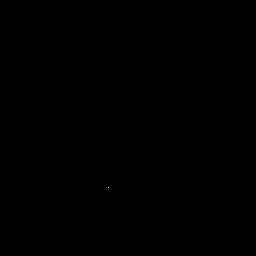

In [35]:
#为什么这里乘以255和不乘以255，一个天线图，一个是街道图呢
Image.fromarray(np.uint8(cond_image.permute(1,2,0)* 255))  #Image.fromarray() 的作用是将 numpy 数组或张量转换为 PIL 图像对象。
                                                            #使用时需要确保数组的值范围在 0-255 之间，且数据类型为 uint8。

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


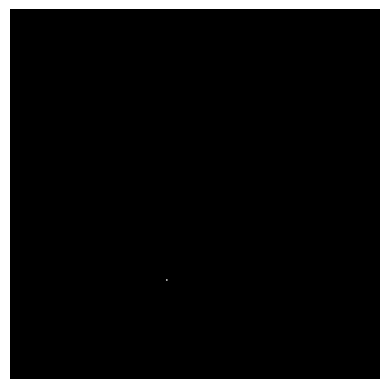

In [85]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
# import torchvision.transforms as tfs



# 6. 显示 cond_image 图像
# 将 tensor 转换为 NumPy 数组用于显示
cond_image_np = (cond_image.permute(1, 2, 0)).detach().numpy()

# 使用 matplotlib 显示图像
plt.imshow(cond_image_np)
plt.axis('off')  # 关闭坐标轴显示
plt.show()

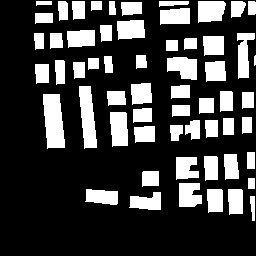

In [86]:
Image.fromarray((np.uint8(cond_image_np)))

In [29]:
antenna_mask = (mask==255)
mask_img = img*(1. - antenna_mask) + antenna_mask
mask_img = np.array(mask_img)
mask_img = np.moveaxis(mask_img, 0, -1)

In [24]:
mask_img.shape

(256, 256, 3)

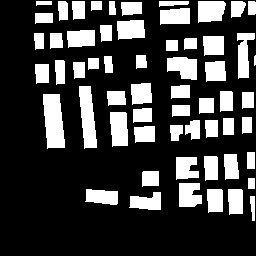

In [30]:
mask_img = Image.fromarray((np.uint8(mask_img )) )
mask_img

In [ ]:
img = tfs(Image.open(path).convert('RGB'))
#在这里改一下mask就行了...
# mask = get_mask()
mask = Image.open(path).convert('RGB').convert("L")
mask = np.array(mask)
# antenna_mask = (mask>=245) 
# mask[mask>=245] = 0
mask[mask > 0] = 1
mask= torch.tensor(np.expand_dims(mask, axis=0))  # 1.添加新维度，变为 (1, H, W)  #mask 是图片的掩码。掩码区域为1.。。...
cond_image = img*(1. - mask) + mask*torch.randn_like(img)
# mask_img = torch.clamp(img*(1. - mask) + mask -antenna_mask, min=0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


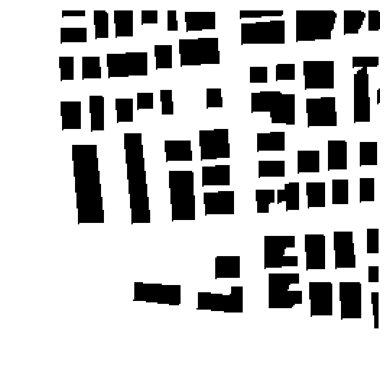

In [48]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as tfs



# 6. 显示 cond_image 图像
# 将 tensor 转换为 NumPy 数组用于显示
cond_image_np = (cond_image.permute(1, 2, 0)).detach().numpy()

# 使用 matplotlib 显示图像
plt.imshow(cond_image_np)
plt.axis('off')  # 关闭坐标轴显示
plt.show()


In [ ]:

# 反标准化后的张量
denormalized_tensor = denormalize(img)

# 转换为 PIL 图像
to_pil_image = transforms.ToPILImage()
result_image = to_pil_image(denormalized_tensor)
result_image

In [34]:
img = Image.open(path).convert('RGB')
img

TypeError: 'Image' object is not subscriptable

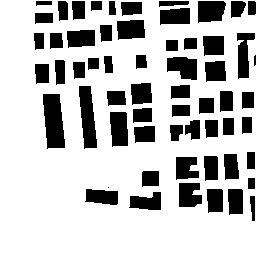

In [36]:
mask = Image.open(path).convert('RGB').convert("L")
mask = np.array(mask)
mask[mask==255] =0
mask[mask > 0] = 255
# mask = 255 - mask #magic invert...
mask = Image.fromarray(mask)
mask

In [39]:
mask = Image.open(path).convert('RGB').convert("L")
mask = np.array(mask)

In [40]:
mask

array([[63, 63, 63, ..., 11, 12, 12],
       [64, 63, 63, ...,  0,  0, 12],
       [64, 64, 64, ...,  0,  0,  0],
       ...,
       [81, 81, 81, ..., 67, 67, 66],
       [80, 80, 80, ..., 67, 67, 67],
       [80, 80, 80, ..., 67, 67, 67]], dtype=uint8)

In [41]:
np.uint8(mask)

array([[63, 63, 63, ..., 11, 12, 12],
       [64, 63, 63, ...,  0,  0, 12],
       [64, 64, 64, ...,  0,  0,  0],
       ...,
       [81, 81, 81, ..., 67, 67, 66],
       [80, 80, 80, ..., 67, 67, 67],
       [80, 80, 80, ..., 67, 67, 67]], dtype=uint8)

In [1]:
import cv2
target = cv2.imread(path)
target[target==255] =0
target[target > 0] = 255
target = Image.fromarray(target)
target

NameError: name 'path' is not defined

In [36]:
new_path = "/home/data/cpu-two/code/diffusionmodel/Palette-Image-to-Image-Diffusion-Models/experiments/train_inpainting_places2_241222_151441/results/val/1/Out_295_61.png"
image = np.array(Image.open(new_path).convert('RGB'))
ti = torch.tensor(image)

In [65]:
import torch

# 假设 tensor 是一个形状为 (256, 256, 3) 的张量
tensor = torch.randn(256, 256, 3)
max_values= torch.argmax(tensor)
# max_indices = torch.nonzero(tensor == max_value.item())

print("最大值：", max_values)
# print("最大值的索引：", max_indices)



最大值： tensor(112729)


In [63]:
max_values.item()

4.737114906311035

In [23]:

torch.sum((l2[0].float() - l1[0].float()) ** 2 + (l2[1].float() - l1[1].float()) ** 2)


tensor(170.)

In [35]:
l2[0].numel() == 0

True

In [13]:
mask = Image.open(path).convert('RGB').convert("L")
mask = np.array(mask)
c=np.where(mask==255)
d=np.where(mask==245)


In [30]:
# import torch
# import numpy as np

# def find_max_positions(tensor):
#     # 获取最大值的索引
#     max_index = torch.argmax(tensor)
#     # 将一维索引转换为多维索引
#     return np.unravel_index(max_index.item(), tensor.shape)

# def euclidean_distance(pos1, pos2):
#     # 计算欧氏距离
#     return torch.norm(torch.tensor(pos1) - torch.tensor(pos2))

# 示例张量
tensor1 = torch.rand(69, 4)
tensor2 = torch.rand(69, 4)
_,dd = tensor1.view(b, -1).max(dim=1)
_,ee = tensor2.view(b, -1).max(dim=1)


In [32]:
(dd != ee).float().mean()

tensor(1.)

In [18]:
# mask_img[:,187,108] =0
# mask_img[:,187,108] 

In [19]:
print("mask:",mask[0,187,108])
print("img:",img.permute(1,2,0)[187,108])
print("cond_image :",cond_image [0,187,108])
print("mask_img :",mask_img[0,187,108])


mask: tensor(0, dtype=torch.uint8)
img: tensor([1., 1., 1.])
cond_image : tensor(1.)
mask_img : tensor(0.)


In [20]:
# mask = Image.open(path).convert('RGB').convert("L")
# mask = np.array(mask)
# indy = np.argwhere(mask == 255)[0]

In [21]:
import json

# 打开 JSON 文件并读取内容
with open('/home/data/cpu-two/code/dataset/radiomapdataset/RadioMapSeer/antenna/0.json', 'r', encoding='utf-8') as file:
    # 使用 json.load() 方法解析 JSON 数据
    data = json.load(file)

# 打印解析后的 Python 对象
print(data)  # 输出: {'name': '张三', 'age': 30, 'city': '北京'}


[[108, 68], [134, 98], [80, 118], [182, 73], [103, 199], [98, 105], [60, 200], [108, 146], [108, 111], [127, 88], [100, 79], [77, 137], [56, 77], [148, 104], [124, 146], [183, 156], [152, 109], [72, 91], [155, 65], [105, 122], [134, 131], [112, 174], [156, 140], [163, 119], [100, 128], [130, 110], [143, 90], [130, 176], [197, 112], [119, 147], [132, 138], [94, 74], [84, 88], [87, 97], [197, 63], [71, 161], [117, 172], [184, 200], [126, 69], [159, 156], [92, 74], [149, 95], [161, 105], [54, 59], [171, 142], [81, 118], [66, 99], [129, 54], [165, 154], [142, 99], [90, 201], [86, 175], [79, 108], [98, 134], [61, 200], [85, 194], [98, 127], [100, 190], [103, 168], [191, 200], [103, 106], [90, 80], [89, 184], [95, 200], [147, 179], [178, 62], [133, 82], [150, 176], [134, 96], [103, 184], [185, 73], [154, 197], [100, 86], [170, 63], [198, 137], [124, 187], [125, 176], [157, 191], [133, 105], [152, 132]]


In [22]:
len(data)

80

In [23]:
data[0]

[108, 68]

In [44]:
mask[0,data[0]]

array([11,  3], dtype=uint8)

In [31]:
mask[indy[0],indy[1]]

255

In [133]:
tk = cond_image.permute(1,2,0)
jk = mask_img.permute(1,2,0)

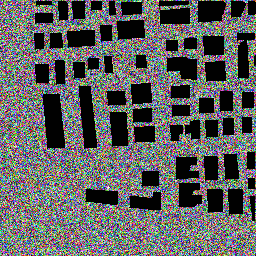

In [29]:
#转换成图像看看
result_image = Image.fromarray(np.uint8(cond_image.permute(1,2,0)* 255)) 
result_image

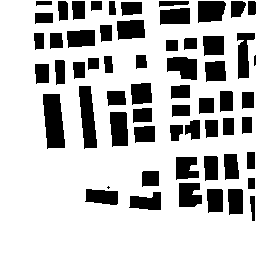

In [30]:
result_image = Image.fromarray(np.uint8(mask_img.permute(1,2,0)* 255)) 
result_image

In [39]:
# 反标准化
def denormalize(tensor):
    # 将张量反标准化到 [0, 1]
    tensor = tensor * 0.5 + 0.5  # 根据 Normalize 的公式反推
    return tensor.clamp(0, 1)     # 确保值在 [0, 1] 范围内


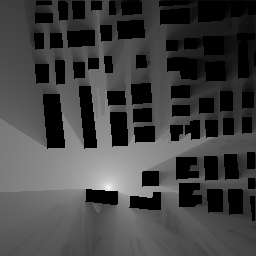

In [40]:

# 反标准化后的张量
denormalized_tensor = denormalize(img)

# 转换为 PIL 图像
to_pil_image = transforms.ToPILImage()
result_image = to_pil_image(denormalized_tensor)
result_image

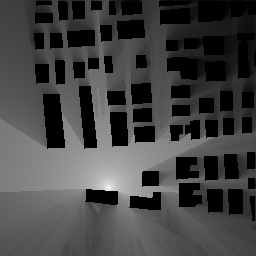

In [ ]:
Image.open(path).convert('RGB')

In [ ]:
import torch.utils.data as data
from torchvision import transforms
from PIL import Image
import os
import torch
import numpy as np
from data.util.mask import (bbox2mask, brush_stroke_mask, get_irregular_mask, random_bbox, random_cropping_bbox)

map_path = "/home/data/cpu-two/code/dataset/radiomapdataset/RadioMapSeer/png/buildings_complete/0.png"
# map_path = "/home/data/cpu-two/code/myproject/dreambooth-lora/cat.png"
antenna_path = "/home/data/cpu-two/code/dataset/radiomapdataset/RadioMapSeer/png/antennas/0_0.png"
tpath = "/home/data/cpu-two/code/dataset/radiomapdataset/RadioMapSeer/gain/carsDPM/0_0.png"
map_image = Image.open(map_path).convert('RGB')
antenna_image = Image.open(antenna_path).convert('RGB')
t_image = Image.open(tpath).convert('RGB')

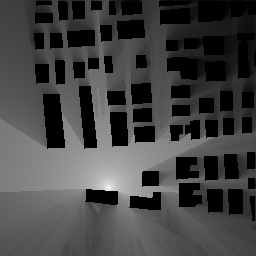

In [ ]:
t_image

In [100]:
# 定义裁剪区域，以(108, 68)为中心，大小为10x10
center_x, center_y = 108, 255-68
crop_size = 2

# 计算裁剪区域的左上角和右下角坐标
left = center_x - crop_size // 2
upper = center_y - crop_size // 2
right = center_x + crop_size // 2
lower = center_y + crop_size // 2

# 裁剪图片
cropped_image = t_image.crop((left, upper, right, lower))

In [101]:
cropped_image

In [ ]:
cropped_image

In [ ]:

ni = np.array(cropped_image)
ni

array([[236, 245],
       [245, 255]], dtype=uint8)

In [ ]:
np.sum(np.array(t_image)==255)

1

In [ ]:
np.sum(np.uint8(cond_image.permute(1,2,0)* 255) ==255)

565

In [ ]:
tfs = transforms.Compose([
                transforms.Resize((256, 256)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5,0.5, 0.5])
                   ])

In [ ]:
img = tfs(map_image)

In [ ]:
mask = bbox2mask([256, 256], random_bbox())
mask = torch.from_numpy(mask).permute(2,0,1)

In [ ]:
cond_image = img*(1. - mask) + mask*torch.randn_like(img)
mask_img = img*(1. - mask) + mask

In [ ]:
mask = torch.from_numpy(mask).permute(2,0,1)

In [ ]:
torch.randn_like(img)

In [ ]:
mask = get_mask()
cond_image = img*(1. - mask) + mask*torch.randn_like(img)
mask_img = img*(1. - mask) + mask

In [ ]:
python run.py -p test -c config/inpainting_celebahq.json

In [ ]:
def get_irregular_mask(img_shape, area_ratio_range=(0.15, 0.5), **kwargs):
    """Get irregular mask with the constraints in mask ratio

    Args:
        img_shape (tuple[int]): Size of the image.
        area_ratio_range (tuple(float)): Contain the minimum and maximum area
        ratio. Default: (0.15, 0.5).

    Returns:
        numpy.ndarray: Mask in the shape of (h, w, 1).
    """

    mask = random_irregular_mask(img_shape, **kwargs)
    min_ratio, max_ratio = area_ratio_range

    while not min_ratio < (np.sum(mask) /
                           (img_shape[0] * img_shape[1])) < max_ratio:
        mask = random_irregular_mask(img_shape, **kwargs)

    return mask

In [ ]:
antenna_image

---------

In [ ]:
import torch.utils.data as data
from torchvision import transforms
from PIL import Image
import os
import torch
import numpy as np
from data.util.mask import (bbox2mask, brush_stroke_mask, get_irregular_mask, random_bbox, random_cropping_bbox)

# map_path = "/home/data/cpu-two/code/dataset/radiomapdataset/RadioMapSeer/png/buildings_complete/0.png"
# map_path = "/home/data/cpu-two/code/myproject/dreambooth-lora/cat.png"
# antenna_path = "/home/data/cpu-two/code/dataset/radiomapdataset/RadioMapSeer/png/antennas/0_0.png"
tpath = "/home/data/cpu-two/code/dataset/radiomapdataset/RadioMapSeer/gain/carsDPM/0_0.png"
# map_image = Image.open(map_path).convert('RGB')
# antenna_image = Image.open(antenna_path).convert('RGB')
t_image = Image.open(tpath).convert('RGB')

In [ ]:
tfs = transforms.Compose([
                transforms.Resize((256, 256)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5,0.5, 0.5])
                   ])

In [ ]:
img = tfs(t_image)
img     #img是ground truth ,经过一系列变换形成的。...

In [ ]:
mask = t_image.convert('L')  # 转换为灰度图像


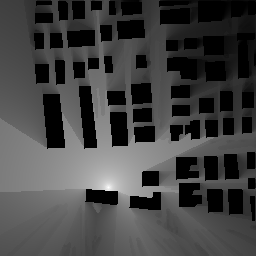

In [ ]:
mask

In [ ]:
mask = np.array(mask)
mask[mask > 0] = 1

In [ ]:
result_image = Image.fromarray(np.uint8(mask * 255)) 

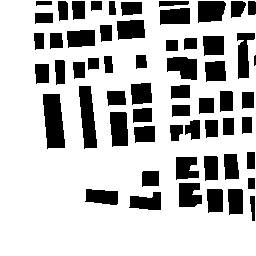

In [ ]:
result_image

In [ ]:
mask= torch.tensor(np.expand_dims(mask, axis=0))  # 添加新维度，变为 (1, H, W)  #mask 是图片的掩码。掩码区域为1.。。...


In [ ]:
# 定义转换
to_tensor = transforms.ToTensor()

# 转换图片为张量
mask = to_tensor(mask_image)  

In [ ]:
red_channel = mask[0,:, :]
green_channel = mask[1,:, :]
blue_channel = mask[2,:, :]

# 比较三个通道的像素值是否相同
channels_equal = np.array_equal(red_channel, green_channel) and np.array_equal(green_channel, blue_channel)


In [ ]:
mask= torch.tensor(np.expand_dims(red_channel, axis=0))  # 添加新维度，变为 (1, H, W)  #mask 是图片的掩码。掩码区域为1.。。...



In [ ]:
cond_image = img*(1. - mask) + mask*torch.randn_like(img)
mask_img = img*(1. - mask) + mask

In [1]:
import torch
print(torch.cuda.is_available())


True


/home/data/cpu-two/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
